In [2]:
import sys
import os
import glob
import collections
import shutil
import subprocess

import numpy as np
import pandas as pd

from openeye import oechem

from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression

from textwrap import wrap
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

%matplotlib inline

%config IPCompleter.greedy=True

In [3]:
CWD = os.getcwd()

try:
    from pfabnet import base
except ModuleNotFoundError as e:
    os.chdir(os.getcwd() + os.sep + '..')
    
from pfabnet import base

In [4]:
from pfabnet.base import ENTITY_KEY, VISCOSITY_KEY

In [5]:
with open('pfabnet/sbatch_tmpl.sh', 'r') as fptr:
    sbatch_tmpl = fptr.read()
    
print(sbatch_tmpl)

#!/bin/bash -l
#SBATCH -e %j.err
#SBATCH -o %j.out
#SBATCH --nodes=1
#SBATCH --gres=gpu:v100:1
#SBATCH --mem=32gb
#SBATCH --wait



In [137]:
sbatch_script = sbatch_tmpl + '#SBATCH --time=0-4:00:00\n#SBATCH --ntasks-per-node=1\n#SBATCH --job-name=predict\n\n'
sbatch_script += 'python pfabnet/predict.py --structure_file $1 '
sbatch_script += '--PfAbNet_model_dir $2 --PfAbNet_model_prefix $3 '
sbatch_script += '--output_file $4 --esp_dir $5 --NX $6 --grid_dim $7 --grid_spacing $8 --shell_width $9\n'

with open('sbatch_predict.sh', 'w') as fptr:
    fptr.write(sbatch_script)

def create_prediction_script(script_file, structure_file_base, model_dir_base, 
                             output_dir_base, ESP_DIR='data/hm/esp', NX=10, 
                             GRID_DIM=96, GRID_SPACING=0.75, SHELL_WIDTH=2.0, script_write_mode='w'):
    with open(script_file, script_write_mode) as fptr:
        for row_idx, row in df_ab21.iterrows():
            entity = row[ENTITY_KEY]
            structure_file = structure_file_base + '/%s.mol2' % entity
            model_dir = model_dir_base + '/pdgf38'
            model_prefix = 'PfAbNet-PDGF38'
            output_file = output_dir_base + '/pdgf38/%s.csv' % entity
            fptr.write('sbatch --export=ALL sbatch_predict.sh %s %s %s %s %s %d %d %.2f %.1f &\n' 
                       % (structure_file, model_dir, model_prefix, output_file, ESP_DIR, 
                          NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH))
            # fptr.write('./sbatch_predict.sh %s %s %s %s %s %d %d %.2f %.1f \n' 
            #            % (structure_file, model_dir, model_prefix, output_file, ESP_DIR, 
            #               NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH))

        for row_idx, row in df_pdgf38.iterrows():
            entity = row[ENTITY_KEY]
            structure_file = structure_file_base + '/%s.mol2' % entity
            model_dir = model_dir_base + '/ab21'
            model_prefix = 'PfAbNet-Ab21'
            output_file = output_dir_base + '/ab21/%s.csv' % entity
            fptr.write('sbatch --export=ALL sbatch_predict.sh %s %s %s %s %s %d %d %.2f %.1f &\n' 
                       % (structure_file, model_dir, model_prefix, output_file, ESP_DIR, 
                          NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH))   
            # fptr.write('./sbatch_predict.sh %s %s %s %s %s %d %d %.2f %.1f \n' 
            #            % (structure_file, model_dir, model_prefix, output_file, ESP_DIR, 
            #               NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH)) 
        fptr.write('wait\n')

In [154]:
def retrieve_prediction_outputs(file_pattern):
    pred_files = glob.glob(file_pattern)
    df_list = []
    for pred_file in pred_files:
        df = pd.read_csv(pred_file)
        df_list.append(df)

    df = pd.concat(df_list)

    return df

In [168]:
def cal_auc(y_mes, y_pred, class_threshold=20):
    y_binary = np.copy(y_mes)
    y_binary[y_binary<=class_threshold] = 0; y_binary[y_binary>class_threshold] = 1
    auc = roc_auc_score(y_binary, y_pred)  
    
    return auc, y_binary

def cal_stderror_auc(y, ypred):
    auc = []
    for i in range(500):
        y1, ypred1 = resample(y, ypred)
        try:
            auc1, _ = cal_auc(y1, ypred1)
            auc.append(auc1)
        except Exception as e:
            pass

    auc = np.array(auc)
    se = 1.96*np.std(auc)/np.sqrt(len(y))

    return se

def cal_stderror_spearmanr(y, ypred):
    r = []
    for i in range(500):
        y1, ypred1 = resample(y, ypred)
        r.append(stats.spearmanr(y1, ypred1).correlation)

    r = np.array(r)
    se = 1.96*np.std(r)/np.sqrt(len(y))

    return se

In [184]:
VISCOSITY_MES = 'Viscosity_at_150'
VISCOSITY_PRED = 'VISCOSITY_PRED'

FONT_SIZE = 18

def plot_multiple_predictions_auc(ax, data, label, ylim_low=0.4, xlabel=None):
    auc_list = []; se_list = []; tick_labels = []
    for tick_label, x, y in data:
        tick_labels.append(tick_label)
        auc, _ = cal_auc(x, y)
        auc_list.append(auc)
        se_list.append(cal_stderror_auc(x, y))
    
    x = np.arange(len(auc_list))
    ax.bar(x, auc_list, yerr=se_list,
          align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylim([ylim_low, 1.0])
    ax.set_xticks(x)
    ax.set_ylabel('ROC-AUC', fontsize=FONT_SIZE)
    ax.set_xticklabels(tick_labels, fontsize=FONT_SIZE)
    ax.text(0.05, 0.93, label, transform=ax.transAxes, fontsize=FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE-2)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=FONT_SIZE)
                  

def plot_multiple_predictions_r(ax, data, label, ylim_low=0.4, xlabel=None):
    rho_list = []; se_list = []; tick_labels = []
    for tick_label, x, y in data:
        tick_labels.append(tick_label)
        rho_list.append(stats.spearmanr(x, y).correlation)
        se_list.append(cal_stderror_spearmanr(x, y))
    
    x = np.arange(len(rho_list))
    ax.bar(x, rho_list, yerr=se_list, 
           align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylim([ylim_low, 1.0])
    ax.set_xticks(x)
    ax.set_ylabel(r'Spearmann rank $\rho$', fontsize=FONT_SIZE)
    ax.set_xticklabels(tick_labels, fontsize=FONT_SIZE)
    ax.text(0.05, 0.93, label, transform=ax.transAxes, fontsize=FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE-2)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=FONT_SIZE)

In [157]:
df_pdgf38 = pd.read_csv('data/PDGF38.csv')
df_ab21 = pd.read_csv('data/Ab21.csv')
df_combined = pd.concat([df_pdgf38, df_ab21])

### Grid spacing

In [158]:
sbatch_script = sbatch_tmpl + '#SBATCH --array=0-9\n#SBATCH --time=0-24:00:00\n#SBATCH --job-name=pfabnet\n\n'
sbatch_script += 'python pfabnet/train.py --training_data_file $1 '
sbatch_script += '--homology_model_dir $2 --output_model_prefix $3 '
sbatch_script += '--output_model_dir $4 --NX $5 --grid_dim $6 --grid_spacing $7 --esp_dir $8 --fold_idx $SLURM_ARRAY_TASK_ID\n'

with open('sbatch_train3.sh', 'w') as fptr:
    fptr.write(sbatch_script)
    
def create_sbatch_script(ESP_DIR, GRID_DIM, GRID_SPACING, NX = 10):
    with open('train_multi_grid_%d.sh' % GRID_DIM, 'w') as fptr:
        fptr.write('sbatch --export=ALL sbatch_train3.sh %s %s %s %s %d %d %.2f %s &\n' % 
                   ('data/PDGF38.csv', 'data/hm', 'PfAbNet-PDGF38', 'models/sensitivity/grid_%d/pdgf38' % GRID_DIM, NX, GRID_DIM, GRID_SPACING, ESP_DIR))
        fptr.write('sbatch --export=ALL sbatch_train3.sh %s %s %s %s %d %d %.2f %s &\n' % 
                   ('data/Ab21.csv', 'data/hm', 'PfAbNet-Ab21', 'models/sensitivity/grid_%d/ab21' % GRID_DIM, NX, GRID_DIM, GRID_SPACING, ESP_DIR))

        fptr.write('wait\n')
    

!mkdir -p models/sensitivity/grid_32/pdgf38
!mkdir -p models/sensitivity/grid_32/ab21
!mkdir -p models/sensitivity/grid_32/esp

#!python pfabnet/esp_generator.py --input_mols_dir data/hm --esp_output_dir models/sensitivity/grid_32/esp --grid_dim 32 --grid_spacing 2.5 --seed 10

create_sbatch_script('models/sensitivity/grid_32/esp', 32, 2.5)
!chmod u+rwx train_multi_grid_32.sh

!mkdir -p models/sensitivity/grid_64/pdgf38
!mkdir -p models/sensitivity/grid_64/ab21
!mkdir -p models/sensitivity/grid_64/esp

#!python pfabnet/esp_generator.py --input_mols_dir data/hm --esp_output_dir models/sensitivity/grid_64/esp --grid_dim 64 --grid_spacing 1.25 --seed 10

create_sbatch_script('models/sensitivity/grid_64/esp', 64, 1.25)
!chmod u+rwx train_multi_grid_64.sh

#!./train_multi_grid_32.sh
#!./train_multi_grid_64.sh


# Prediction
create_prediction_script('predict_grid32.sh', 'data/hm', 'models/sensitivity/grid_32', 
                         'models/sensitivity/grid_32', ESP_DIR='models/sensitivity/grid_32/esp', 
                         GRID_DIM=32, GRID_SPACING=2.5, NX=10)
create_prediction_script('predict_grid64.sh', 'data/hm', 'models/sensitivity/grid_64', 
                         'models/sensitivity/grid_64', ESP_DIR='models/sensitivity/grid_64/esp', 
                         GRID_DIM=64, GRID_SPACING=1.25, NX=10)

!chmod u+rwx predict_grid32.sh
!chmod u+rwx predict_grid64.sh

#!./predict_grid32.sh
#!./predict_grid64.sh

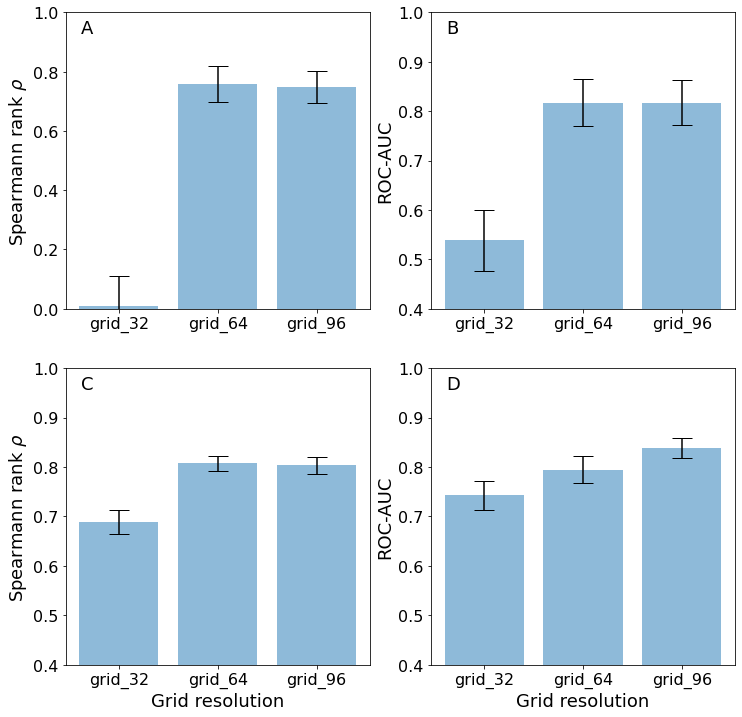

In [185]:
def get_data(dirnames):
    data = []
    for dirname, grid_dim in zip(dirnames, [32, 64, 96]):
        df_pred = retrieve_prediction_outputs(dirname + '/*.csv')
        df = df_combined.merge(df_pred, on=ENTITY_KEY)
        df.loc[df[VISCOSITY_MES] > 1000, VISCOSITY_MES] = 1000
        x_data, y_data = df[VISCOSITY_MES].values, df[VISCOSITY_PRED].values
        data.append(('grid_%d' % grid_dim, x_data, y_data))
        
    return data

nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols,6*nrows))

data = get_data(['models/sensitivity/grid_32/pdgf38', 'models/sensitivity/grid_64/pdgf38', 'models/pdgf38'])
plot_multiple_predictions_r(axs[0,0], data, 'A', 0.)
plot_multiple_predictions_auc(axs[0,1], data, 'B')

data = get_data(['models/sensitivity/grid_32/ab21', 'models/sensitivity/grid_64/ab21', 'models/ab21'])
plot_multiple_predictions_r(axs[1,0], data, 'C', xlabel='Grid resolution')
plot_multiple_predictions_auc(axs[1,1], data, 'D', xlabel='Grid resolution')

### ESP surface shell thickness

In [173]:
sbatch_script = sbatch_tmpl + '#SBATCH --array=0-9\n#SBATCH --time=0-24:00:00\n#SBATCH --job-name=pfabnet\n\n'
sbatch_script += 'python pfabnet/train.py --training_data_file $1 '
sbatch_script += '--homology_model_dir $2 --output_model_prefix $3 '
sbatch_script += '--output_model_dir $4 --NX $5 --grid_dim $6 --grid_spacing $7 --shell_width $8 --esp_dir $9 --fold_idx $SLURM_ARRAY_TASK_ID\n'

with open('sbatch_train4.sh', 'w') as fptr:
    fptr.write(sbatch_script)
    
def create_sbatch_script(ESP_DIR, SHELL_WIDTH, GRID_DIM = 96, GRID_SPACING = 0.75, NX = 10):
    with open('train_multi_shell_%d.sh' % SHELL_WIDTH, 'w') as fptr:
        fptr.write('sbatch --export=ALL sbatch_train4.sh %s %s %s %s %d %d %.2f %.1f %s &\n' % 
                   ('data/PDGF38.csv', 'data/hm', 'PfAbNet-PDGF38', 'models/sensitivity/shell_%d/pdgf38' % SHELL_WIDTH, NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH, ESP_DIR))
        fptr.write('sbatch --export=ALL sbatch_train4.sh %s %s %s %s %d %d %.2f %.1f %s &\n' % 
                   ('data/Ab21.csv', 'data/hm', 'PfAbNet-Ab21', 'models/sensitivity/shell_%d/ab21' % SHELL_WIDTH, NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH, ESP_DIR))

        fptr.write('wait\n')
    

!mkdir -p models/sensitivity/shell_1/pdgf38
!mkdir -p models/sensitivity/shell_1/ab21
!mkdir -p models/sensitivity/shell_1/esp
#!python pfabnet/esp_generator.py --input_mols_dir data/hm --esp_output_dir models/sensitivity/shell_1/esp --shell_width 1 --seed 10

create_sbatch_script('models/sensitivity/shell_1/esp', 1)
!chmod u+rwx train_multi_shell_1.sh

!mkdir -p models/sensitivity/shell_3/pdgf38
!mkdir -p models/sensitivity/shell_3/ab21
!mkdir -p models/sensitivity/shell_3/esp
#!python pfabnet/esp_generator.py --input_mols_dir data/hm --esp_output_dir models/sensitivity/shell_3/esp --shell_width 3 --seed 10

create_sbatch_script('models/sensitivity/shell_3/esp', 3)
!chmod u+rwx train_multi_shell_3.sh

!mkdir -p models/sensitivity/shell_100/pdgf38
!mkdir -p models/sensitivity/shell_100/ab21
!mkdir -p models/sensitivity/shell_100/esp
#!python pfabnet/esp_generator.py --input_mols_dir data/hm --esp_output_dir models/sensitivity/shell_100/esp --shell_width 100 --seed 10

create_sbatch_script('models/sensitivity/shell_100/esp', 100)
!chmod u+rwx train_multi_shell_100.sh

#!./train_multi_shell_1.sh
#!./train_multi_shell_3.sh
#!./train_multi_shell_100.sh

# Prediction
create_prediction_script('predict_shell_1.sh', 'data/hm', 'models/sensitivity/shell_1', 'models/sensitivity/shell_1', ESP_DIR='data/hm/esp', SHELL_WIDTH=1.0, NX=10)
create_prediction_script('predict_shell_3.sh', 'data/hm', 'models/sensitivity/shell_3', 'models/sensitivity/shell_3', ESP_DIR='data/hm/esp', SHELL_WIDTH=3.0, NX=10)
create_prediction_script('predict_shell_100.sh', 'data/hm', 'models/sensitivity/shell_100', 'models/sensitivity/shell_100', ESP_DIR='data/hm/esp', SHELL_WIDTH=100.0, NX=10)

!chmod u+rwx predict_shell_1.sh
!chmod u+rwx predict_shell_3.sh
!chmod u+rwx predict_shell_100.sh

# !./predict_NX_1.sh
# !./predict_NX_3.sh
# !./predict_NX_5.sh

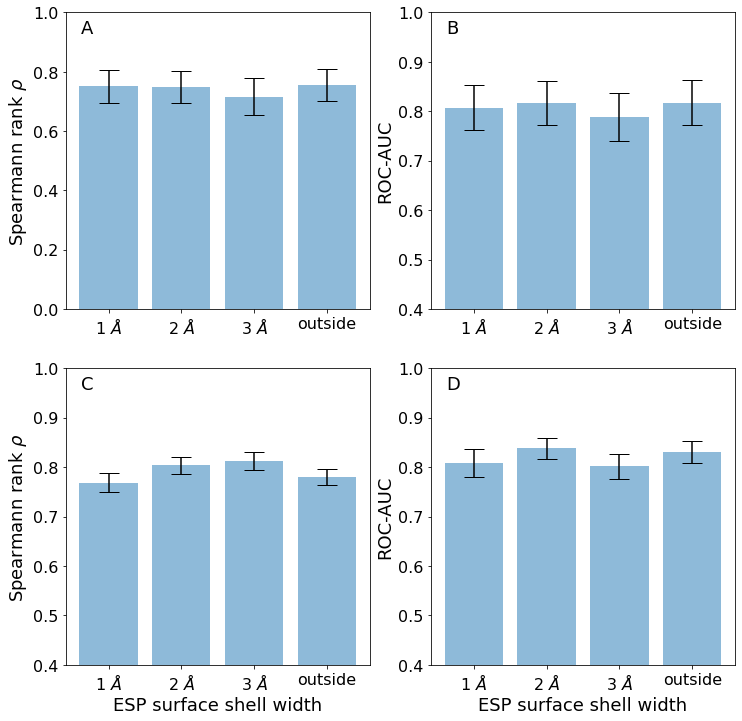

In [191]:
def get_data(dirnames):
    data = []
    for dirname, shell_width in zip(dirnames, [r'1 $\AA$', r'2 $\AA$', r'3 $\AA$', 'outside']):
        df_pred = retrieve_prediction_outputs(dirname + '/*.csv')
        df = df_combined.merge(df_pred, on=ENTITY_KEY)
        df.loc[df[VISCOSITY_MES] > 1000, VISCOSITY_MES] = 1000
        x_data, y_data = df[VISCOSITY_MES].values, df[VISCOSITY_PRED].values
        data.append(('%s' % shell_width, x_data, y_data))
        
    return data

nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols,6*nrows))

data = get_data(['models/sensitivity/shell_1/pdgf38', 'models/pdgf38', 'models/sensitivity/shell_3/pdgf38', 'models/sensitivity/shell_100/pdgf38'])
plot_multiple_predictions_r(axs[0,0], data, 'A', 0.)
plot_multiple_predictions_auc(axs[0,1], data, 'B')

data = get_data(['models/sensitivity/shell_1/ab21', 'models/ab21', 'models/sensitivity/shell_3/ab21', 'models/sensitivity/shell_100/ab21'])
plot_multiple_predictions_r(axs[1,0], data, 'C', xlabel='ESP surface shell width')
plot_multiple_predictions_auc(axs[1,1], data, 'D', xlabel='ESP surface shell width')

### Data augmentation

In [37]:
sbatch_script = sbatch_tmpl + '#SBATCH --array=0-9\n#SBATCH --time=0-24:00:00\n#SBATCH --job-name=pfabnet\n\n'
sbatch_script += 'python pfabnet/train.py --training_data_file $1 '
sbatch_script += '--homology_model_dir $2 --output_model_prefix $3 '
sbatch_script += '--output_model_dir $4 --NX $5 --grid_dim $6 --grid_spacing $7 --esp_dir $8 --fold_idx $SLURM_ARRAY_TASK_ID\n'

with open('sbatch_train2.sh', 'w') as fptr:
    fptr.write(sbatch_script)
    
def create_sbatch_script(NX):
    GRID_DIM = 96
    GRID_SPACING = 0.75
    ESP_DIR = 'data/hm/esp'
    with open('train_multi_NX_%d.sh' % NX, 'w') as fptr:
        fptr.write('sbatch --export=ALL sbatch_train2.sh %s %s %s %s %d %d %.2f %s &\n' % 
                   ('data/PDGF38.csv', 'data/hm', 'PfAbNet-PDGF38', 'models/sensitivity/NX_%d/pdgf38' % NX, NX, GRID_DIM, GRID_SPACING, ESP_DIR))
        fptr.write('sbatch --export=ALL sbatch_train2.sh %s %s %s %s %d %d %.2f %s &\n' % 
                   ('data/Ab21.csv', 'data/hm', 'PfAbNet-Ab21', 'models/sensitivity/NX_%d/ab21' % NX, NX, GRID_DIM, GRID_SPACING, ESP_DIR))

        fptr.write('wait\n')
    

!mkdir -p models/sensitivity/NX_1/pdgf38
!mkdir -p models/sensitivity/NX_1/ab21
create_sbatch_script(1)
!chmod u+rwx train_multi_NX_1.sh

!mkdir -p models/sensitivity/NX_3/pdgf38
!mkdir -p models/sensitivity/NX_3/ab21
create_sbatch_script(3)
!chmod u+rwx train_multi_NX_3.sh

!mkdir -p models/sensitivity/NX_5/pdgf38
!mkdir -p models/sensitivity/NX_5/ab21
create_sbatch_script(5)
!chmod u+rwx train_multi_NX_5.sh

#!./train_multi_NX_1.sh
#!./train_multi_NX_3.sh
#!./train_multi_NX_5.sh

# Prediction
create_prediction_script('predict_NX_1.sh', 'data/hm', 'models/sensitivity/NX_1', 'models/sensitivity/NX_1', ESP_DIR='data/hm/esp', NX=1)
create_prediction_script('predict_NX_3.sh', 'data/hm', 'models/sensitivity/NX_3', 'models/sensitivity/NX_3', ESP_DIR='data/hm/esp', NX=3)
create_prediction_script('predict_NX_5.sh', 'data/hm', 'models/sensitivity/NX_5', 'models/sensitivity/NX_5', ESP_DIR='data/hm/esp', NX=5)

!chmod u+rwx predict_NX_1.sh
!chmod u+rwx predict_NX_3.sh
!chmod u+rwx predict_NX_5.sh

# !./predict_NX_1.sh
# !./predict_NX_3.sh
# !./predict_NX_5.sh


!mkdir -p models/sensitivity/NX_3/NX_1/pdgf38
!mkdir -p models/sensitivity/NX_3/NX_1/ab21
!mkdir -p models/sensitivity/NX_5/NX_1/pdgf38
!mkdir -p models/sensitivity/NX_5/NX_1/ab21
create_prediction_script('predict_NX_3_NX_1.sh', 'data/hm', 'models/sensitivity/NX_3', 'models/sensitivity/NX_3/NX_1', ESP_DIR='data/hm/esp', NX=1)
create_prediction_script('predict_NX_5_NX_1.sh', 'data/hm', 'models/sensitivity/NX_5', 'models/sensitivity/NX_5/NX_1', ESP_DIR='data/hm/esp', NX=1)

!chmod u+rwx predict_NX_3_NX_1.sh
!chmod u+rwx predict_NX_5_NX_1.sh

# !./predict_NX_3_NX_1.sh
# !./predict_NX_5_NX_1.sh

!mkdir -p models/NX_1/pdgf38
!mkdir -p models/NX_1/ab21
!mkdir -p models/NX_3/pdgf38
!mkdir -p models/NX_3/ab21
!mkdir -p models/NX_5/pdgf38
!mkdir -p models/NX_5/ab21
create_prediction_script('predict_NX_10_NX_1.sh', 'data/hm', 'models', 'models/NX_1', ESP_DIR='data/hm/esp', NX=1)
create_prediction_script('predict_NX_10_NX_3.sh', 'data/hm', 'models', 'models/NX_3', ESP_DIR='data/hm/esp', NX=3)
create_prediction_script('predict_NX_10_NX_5.sh', 'data/hm', 'models', 'models/NX_5', ESP_DIR='data/hm/esp', NX=5)

!chmod u+rwx predict_NX_10_NX_1.sh
!chmod u+rwx predict_NX_10_NX_3.sh
!chmod u+rwx predict_NX_10_NX_5.sh

# !./predict_NX_10_NX_1.sh
# !./predict_NX_10_NX_3.sh
# !./predict_NX_10_NX_5.sh

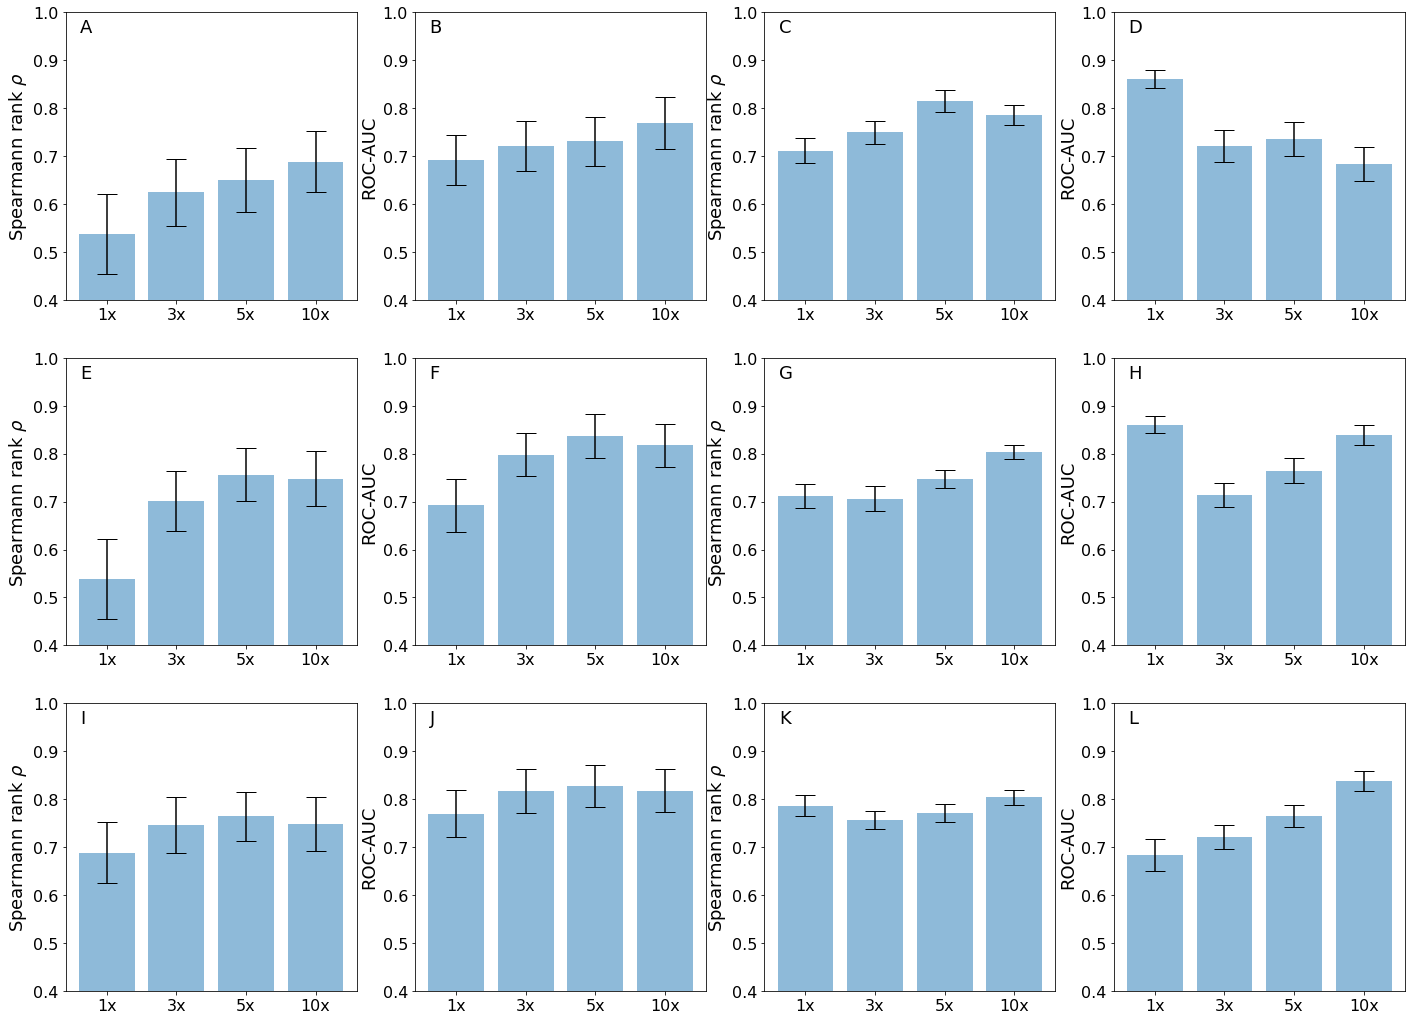

In [171]:
def get_data(dirnames):
    data = []
    for dirname, augx in zip(dirnames, [1, 3, 5, 10]):
        df_pred = retrieve_prediction_outputs(dirname + '/*.csv')
        df = df_combined.merge(df_pred, on=ENTITY_KEY)
        df.loc[df[VISCOSITY_MES] > 1000, VISCOSITY_MES] = 1000
        x_data, y_data = df[VISCOSITY_MES].values, df[VISCOSITY_PRED].values
        data.append(('%dx'%augx, x_data, y_data))
        
    return data

nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols,6*nrows))

data = get_data(['models/sensitivity/NX_1/pdgf38', 'models/sensitivity/NX_3/NX_1/pdgf38', 'models/sensitivity/NX_5/NX_1/pdgf38', 'models/NX_1/pdgf38'])
plot_multiple_predictions_r(axs[0,0], data, 'A')
plot_multiple_predictions_auc(axs[0,1], data, 'B')

data = get_data(['models/sensitivity/NX_1/ab21', 'models/sensitivity/NX_3/NX_1/ab21', 'models/sensitivity/NX_5/NX_1/ab21', 'models/NX_1/ab21'])
plot_multiple_predictions_r(axs[0,2], data, 'C')
plot_multiple_predictions_auc(axs[0,3], data, 'D')

data = get_data(['models/sensitivity/NX_1/pdgf38', 'models/sensitivity/NX_3/pdgf38', 'models/sensitivity/NX_5/pdgf38', 'models/pdgf38'])
plot_multiple_predictions_r(axs[1,0], data, 'E')
plot_multiple_predictions_auc(axs[1,1], data, 'F')

data = get_data(['models/sensitivity/NX_1/ab21', 'models/sensitivity/NX_3/ab21', 'models/sensitivity/NX_5/ab21', 'models/ab21'])
plot_multiple_predictions_r(axs[1,2], data, 'G')
plot_multiple_predictions_auc(axs[1,3], data, 'H')

data = get_data(['models/NX_1/pdgf38', 'models/NX_3/pdgf38', 'models/NX_5/pdgf38', 'models/pdgf38'])
plot_multiple_predictions_r(axs[2,0], data, 'I')
plot_multiple_predictions_auc(axs[2,1], data, 'J')

data = get_data(['models/NX_1/ab21', 'models/NX_3/ab21', 'models/NX_5/ab21', 'models/ab21'])
plot_multiple_predictions_r(axs[2,2], data, 'K')
plot_multiple_predictions_auc(axs[2,3], data, 'L')


### Sensitivity to alternative input structures

In [78]:
# generate ESP
sbatch_script = sbatch_tmpl + '#SBATCH --time=0-4:00:00\n#SBATCH --ntasks-per-node=10\n#SBATCH --job-name=esp\n\n'
sbatch_script += 'python pfabnet/esp_generator.py --input_mols_dir $1 '
sbatch_script += '--esp_output_dir $2 --seed 10 '
sbatch_script = sbatch_script.replace('#SBATCH --gres=gpu:v100:1\n', '')

with open('sbatch_espgen.sh', 'w') as fptr:
    fptr.write(sbatch_script)

with open('espgen_multi.sh', 'w') as fptr:
    for i in range(1, 11):
        base_dir = 'models/sensitivity/hm10/'
        os.makedirs('%s/struct_%d/pdgf38' % (base_dir, i), exist_ok=True)
        os.makedirs('%s/struct_%d/ab21' % (base_dir, i), exist_ok=True)
        esp_output_dir = '%s/struct_%d/esp' % (base_dir, i)
        os.makedirs(esp_output_dir, exist_ok=True)
        
        input_mol_dir = 'data/hm10/struct_%d' % i
        fptr.write('sbatch --export=ALL sbatch_espgen.sh %s %s &\n' % (input_mol_dir, esp_output_dir))
    
    fptr.write('wait\n')
    
!chmod u+x espgen_multi.sh

In [97]:
sbatch_script = sbatch_tmpl + '#SBATCH --array=0-9\n#SBATCH --time=0-24:00:00\n#SBATCH --job-name=pfabnet\n\n'
sbatch_script += 'python pfabnet/train.py --training_data_file $1 '
sbatch_script += '--homology_model_dir $2 --output_model_prefix $3 '
sbatch_script += '--output_model_dir $4 --NX $5 --grid_dim $6 --grid_spacing $7 --esp_dir $8 --fold_idx $SLURM_ARRAY_TASK_ID\n'

with open('sbatch_train_hm10.sh', 'w') as fptr:
    fptr.write(sbatch_script)
    
def create_sbatch_script(script_file):
    NX = 10
    GRID_DIM = 96
    GRID_SPACING = 0.75
    with open(script_file, 'w') as fptr:
        for i in range(1, 11):
            ESP_DIR = 'models/sensitivity/hm10/struct_%d/esp' % i
            fptr.write('sbatch --export=ALL sbatch_train_hm10.sh %s %s %s %s %d %d %.2f %s &\n' % 
                       ('data/PDGF38.csv', 'data/hm10/struct_%d' % i, 'PfAbNet-PDGF38', 'models/sensitivity/hm10/struct_%d/pdgf38' % i, NX, GRID_DIM, GRID_SPACING, ESP_DIR))
            fptr.write('sbatch --export=ALL sbatch_train_hm10.sh %s %s %s %s %d %d %.2f %s &\n' % 
                       ('data/Ab21.csv', 'data/hm10/struct_%d' % i, 'PfAbNet-Ab21', 'models/sensitivity/hm10/struct_%d/ab21' % i, NX, GRID_DIM, GRID_SPACING, ESP_DIR))

        fptr.write('wait\n')
        
create_sbatch_script('train_multi_hm10.sh')
!chmod u+x 'train_multi_hm10.sh'

#./train_multi_hm10.sh

In [97]:
# generate prediction script
script_name = 'predict_hm10.sh'
for i in range(1, 11):
    create_prediction_script('predict_hm10.sh', 'data/hm', 'models/sensitivity/hm10/struct_%d/' % i, 
                             'models/sensitivity/hm10/struct_%d/' % i, ESP_DIR='models/sensitivity/hm10/struct_%d/esp' % i, NX=10, script_write_mode='a')
    
!chmod u+x predict_hm10.sh
#./predict_hm10.sh

In [192]:
def get_prediction_output(df_in, test_set):
    df_out = df_in.copy()
    for i in range(1, 11):
        df_pred = retrieve_prediction_outputs('models/sensitivity/hm10/struct_%d/%s' % (i, test_set) + '/*.csv')
        df_out = df_out.merge(df_pred, on=ENTITY_KEY, suffixes=('', '_%d'%i))
        
    df_out.loc[df_out[VISCOSITY_MES] > 1000, VISCOSITY_MES] = 1000
    return df_out

df_hm10_ab21 = get_prediction_output(df_ab21, 'pdgf38')
df_hm10_pdgf38 = get_prediction_output(df_pdgf38, 'ab21')

df_hm10_ab21.rename(columns={'VISCOSITY_PRED': 'VISCOSITY_PRED_1'}, inplace=True)
df_hm10_pdgf38.rename(columns={'VISCOSITY_PRED': 'VISCOSITY_PRED_1'}, inplace=True)

In [193]:
def generate_eb_plot(axs, x, y, yerr, label):
    FONT_SIZE = 18
    axs.errorbar(x, y, yerr=yerr, fmt='o')
    axs.text(0.05, 0.93, label, transform=axs.transAxes, fontsize=FONT_SIZE)
    axs.set_xlabel('Measured', fontsize=FONT_SIZE)
    axs.set_ylabel('Prediction', fontsize=FONT_SIZE)
    axs.tick_params(axis='both', which='major', labelsize=FONT_SIZE-2)

PDGF38 mu/sigma: 0.34
Ab21 mu/sigma: 0.37


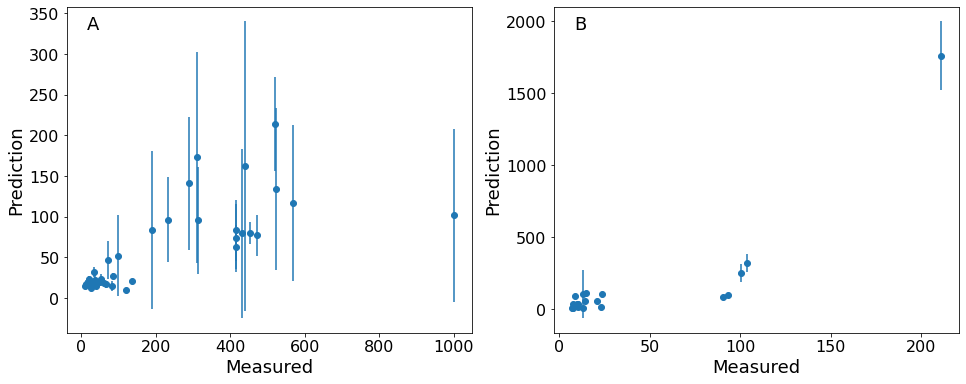

In [196]:
nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols,6*nrows))

NUM_STRUCT = 10
ypred_mean = np.mean(np.array([df_hm10_pdgf38['VISCOSITY_PRED_%d'%i] for i in range(1,NUM_STRUCT+1)]), axis=0)
ypred_std = np.std(np.array([df_hm10_pdgf38['VISCOSITY_PRED_%d'%i] for i in range(1,NUM_STRUCT+1)]), axis=0)
print('PDGF38 mu/sigma: %.2f' % np.median(ypred_std/ypred_mean))
yerr_pdgf = 1.96*ypred_std/np.sqrt(NUM_STRUCT)
generate_eb_plot(axs[0], df_hm10_pdgf38[VISCOSITY_MES], df_hm10_pdgf38['VISCOSITY_PRED_1'], yerr_pdgf, 'A')

ypred_mean = np.mean(np.array([df_hm10_ab21['VISCOSITY_PRED_%d'%i] for i in range(1,NUM_STRUCT+1)]), axis=0)
ypred_std = np.std(np.array([df_hm10_ab21['VISCOSITY_PRED_%d'%i] for i in range(1,NUM_STRUCT+1)]), axis=0)
print('Ab21 mu/sigma: %.2f' % np.median(ypred_std/ypred_mean))

yerr_ab21 = 1.96*ypred_std/np.sqrt(NUM_STRUCT)
generate_eb_plot(axs[1], df_hm10_ab21[VISCOSITY_MES], df_hm10_ab21['VISCOSITY_PRED_1'], yerr_ab21, 'B')

In [195]:
def in_same_class(x):
    mu = x[VISCOSITY_KEY]
    sigma = x['CONF_INTERVAL']
    if mu >= 20:
        if (mu - sigma) >= 20:
            return True
    if mu < 20:
        if (mu + sigma) < 20:
            return True
        
    return False

df_tmp1 = pd.DataFrame(list(zip(df_hm10_pdgf38[VISCOSITY_KEY].values, yerr_pdgf)), 
                      columns=[VISCOSITY_KEY, 'CONF_INTERVAL'])
df_tmp2 = pd.DataFrame(list(zip(df_hm10_ab21[VISCOSITY_KEY].values, yerr_ab21)), 
                      columns=[VISCOSITY_KEY, 'CONF_INTERVAL'])
df_tmp = pd.concat([df_tmp1, df_tmp2])
df_tmp['same_class'] = df_tmp.apply(lambda x: in_same_class(x), axis=1)
print('fraction in same class: %.2f' % (np.sum(df_tmp['same_class'].values) / len(df_tmp)))
df_tmp.head()

fraction in same class: 0.80


,Viscosity_at_150,CONF_INTERVAL,same_class
0,440.0,178.206986,True
1,288.0,81.634602,True
2,523.0,99.414290,True
3,310.0,129.703476,True
4,190.0,97.361568,True


### Performance of Eisenberg hydrophobicity representation

In [96]:
# generate ESP
sbatch_script = sbatch_tmpl + '#SBATCH --time=0-4:00:00\n#SBATCH --ntasks-per-node=10\n#SBATCH --job-name=esp\n\n'
sbatch_script += 'python pfabnet_eisenberg/eisenberg_generator.py --input_mols_dir $1 '
sbatch_script += '--eisenberg_output_dir $2 --seed 10 '
sbatch_script = sbatch_script.replace('#SBATCH --gres=gpu:v100:1\n', '')

with open('sbatch_eisenberg_gen.sh', 'w') as fptr:
    fptr.write(sbatch_script)

with open('eisenberg_gen_multi.sh', 'w') as fptr:
    eisenberg_output_dir = 'models/sensitivity/eisenberg/'
    os.makedirs(eisenberg_output_dir, exist_ok=True)

    input_mol_dir = 'data/hm/'
    fptr.write('sbatch --export=ALL sbatch_eisenberg_gen.sh %s %s &\n' % (input_mol_dir, eisenberg_output_dir))
    
    fptr.write('wait\n')
    
!chmod u+x eisenberg_gen_multi.sh

#./eisenberg_gen_multi.sh

In [116]:
sbatch_script = sbatch_tmpl + '#SBATCH --array=0-9\n#SBATCH --time=0-24:00:00\n#SBATCH --job-name=pfabnet\n\n'
sbatch_script += 'python pfabnet_eisenberg/train.py --training_data_file $1 '
sbatch_script += '--homology_model_dir $2 --output_model_prefix $3 '
sbatch_script += '--output_model_dir $4 --NX $5 --grid_dim $6 --grid_spacing $7 --eisenberg_dir $8 --num_channels $9 --fold_idx $SLURM_ARRAY_TASK_ID\n'

with open('sbatch_train_eisenberg.sh', 'w') as fptr:
    fptr.write(sbatch_script)
    
!mkdir -p models/sensitivity/eisenberg2/pdgf38
!mkdir -p models/sensitivity/eisenberg2/ab21
!mkdir -p models/sensitivity/eisenberg3/pdgf38
!mkdir -p models/sensitivity/eisenberg3/ab21
def create_sbatch_script(script_file, num_channels=2):
    NX = 10
    GRID_DIM = 96
    GRID_SPACING = 0.75
    with open(script_file, 'w') as fptr:
        ESP_DIR = 'models/sensitivity/eisenberg/esp'
        fptr.write('sbatch --export=ALL sbatch_train_eisenberg.sh %s %s %s %s %d %d %.2f %s %d &\n' % 
                   ('data/PDGF38.csv', 'data/hm', 'PfAbNet-PDGF38', 'models/sensitivity/eisenberg%d/pdgf38' % num_channels, NX, GRID_DIM, GRID_SPACING, ESP_DIR, num_channels))
        fptr.write('sbatch --export=ALL sbatch_train_eisenberg.sh %s %s %s %s %d %d %.2f %s %d &\n' % 
                   ('data/Ab21.csv', 'data/hm', 'PfAbNet-Ab21', 'models/sensitivity/eisenberg%d/ab21' % num_channels, NX, GRID_DIM, GRID_SPACING, ESP_DIR, num_channels))

        fptr.write('wait\n')
        
create_sbatch_script('train_multi_eisenberg2.sh', num_channels=2)
create_sbatch_script('train_multi_eisenberg3.sh', num_channels=3)

!chmod u+x 'train_multi_eisenberg2.sh'
!chmod u+x 'train_multi_eisenberg3.sh'

#./train_multi_eisenberg2.sh
#./train_multi_eisenberg3.sh

In [141]:
# predict
sbatch_script = sbatch_tmpl + '#SBATCH --time=0-4:00:00\n#SBATCH --ntasks-per-node=1\n#SBATCH --job-name=predict\n\n'
sbatch_script += 'python pfabnet_eisenberg/predict.py --structure_file $1 '
sbatch_script += '--PfAbNet_model_dir $2 --PfAbNet_model_prefix $3 '
sbatch_script += '--output_file $4 --eisenberg_dir $5 --NX $6 --grid_dim $7 --grid_spacing $8 --shell_width $9 --num_channels ${10}\n'

with open('sbatch_eisenberg_predict.sh', 'w') as fptr:
    fptr.write(sbatch_script)

def create_eisenberg_prediction_script(script_file, structure_file_base, model_dir_base, 
                             output_dir_base, ESP_DIR='models/sensitivity/eisenberg/esp', NX=10, 
                             GRID_DIM=96, GRID_SPACING=0.75, SHELL_WIDTH=2.0, NUM_CHANNELS=2, script_write_mode='w'):
    with open(script_file, script_write_mode) as fptr:
        for row_idx, row in df_ab21.iterrows():
            entity = row[ENTITY_KEY]
            structure_file = structure_file_base + '/%s.mol2' % entity
            model_dir = model_dir_base + '/pdgf38'
            model_prefix = 'PfAbNet-PDGF38'
            output_file = output_dir_base + '/pdgf38/%s.csv' % entity
            # fptr.write('sbatch --export=ALL sbatch_eisenberg_predict.sh %s %s %s %s %s %d %d %.2f %.1f %d &\n' 
            #            % (structure_file, model_dir, model_prefix, output_file, ESP_DIR, 
            #               NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH, NUM_CHANNELS))
            fptr.write('./sbatch_eisenberg_predict.sh %s %s %s %s %s %d %d %.2f %.1f %d \n' 
                       % (structure_file, model_dir, model_prefix, output_file, ESP_DIR, 
                          NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH, NUM_CHANNELS))

        for row_idx, row in df_pdgf38.iterrows():
            entity = row[ENTITY_KEY]
            structure_file = structure_file_base + '/%s.mol2' % entity
            model_dir = model_dir_base + '/ab21'
            model_prefix = 'PfAbNet-Ab21'
            output_file = output_dir_base + '/ab21/%s.csv' % entity
            # fptr.write('sbatch --export=ALL sbatch_eisenberg_predict.sh %s %s %s %s %s %d %d %.2f %.1f %d &\n' 
            #            % (structure_file, model_dir, model_prefix, output_file, ESP_DIR, 
            #               NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH, NUM_CHANNELS))   
            fptr.write('./sbatch_eisenberg_predict.sh %s %s %s %s %s %d %d %.2f %.1f %d \n' 
                       % (structure_file, model_dir, model_prefix, output_file, ESP_DIR, 
                          NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH, NUM_CHANNELS)) 
        fptr.write('wait\n')
        
create_eisenberg_prediction_script('eisenberg_predict2.sh', 'data/hm', 'models/sensitivity/eisenberg2', 'models/sensitivity/eisenberg2', NUM_CHANNELS=2)
create_eisenberg_prediction_script('eisenberg_predict3.sh', 'data/hm', 'models/sensitivity/eisenberg3', 'models/sensitivity/eisenberg3', NUM_CHANNELS=3)

!chmod u+x eisenberg_predict2.sh
!chmod u+x eisenberg_predict3.sh

#!./eisenberg_predict2.sh
#!./eisenberg_predict3.sh

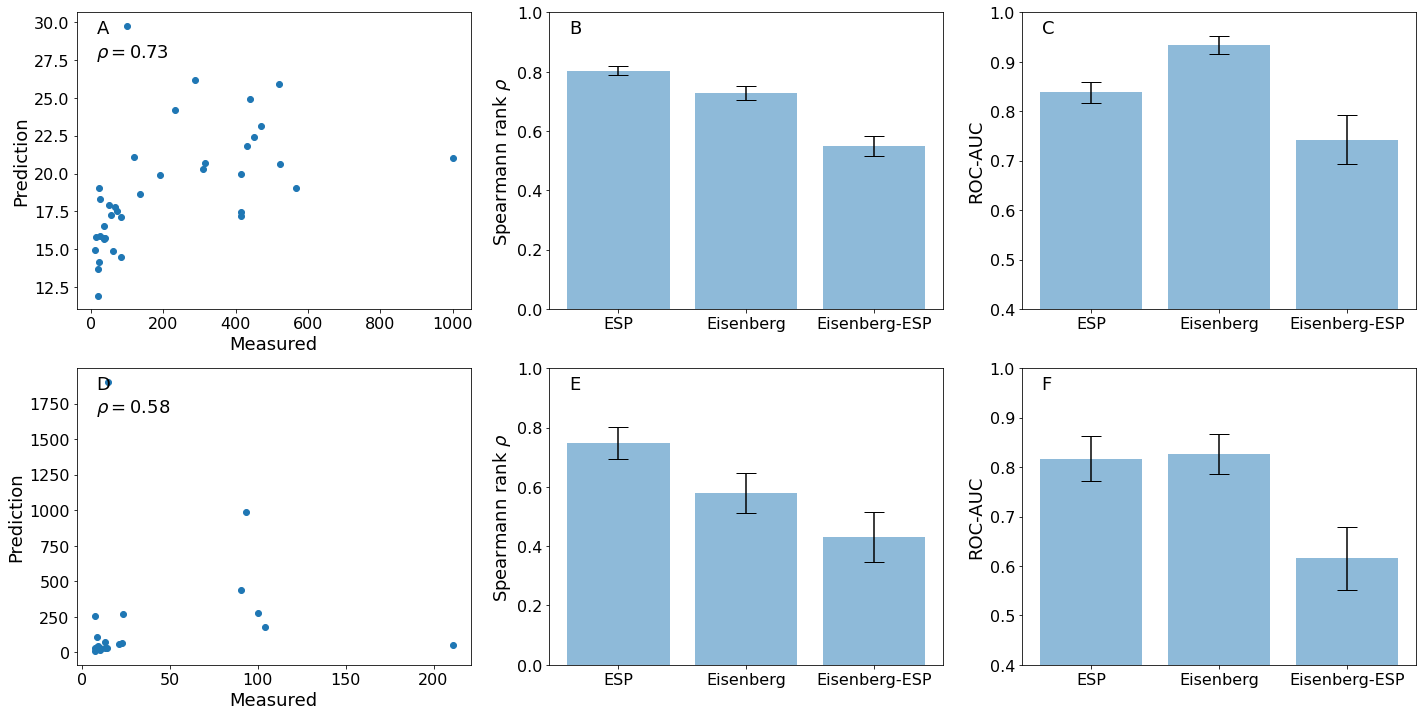

In [183]:
def get_data(dirnames):
    data = []
    for dirname, shell_width in zip(dirnames, ['ESP', 'Eisenberg', 'Eisenberg-ESP']):
        df_pred = retrieve_prediction_outputs(dirname + '/*.csv')
        df = df_combined.merge(df_pred, on=ENTITY_KEY)
        df.loc[df[VISCOSITY_MES] > 1000, VISCOSITY_MES] = 1000
        x_data, y_data = df[VISCOSITY_MES].values, df[VISCOSITY_PRED].values
        data.append(('%s' % shell_width, x_data, y_data))
        
    return data

FONT_SIZE = 18
def generate_scatter_plot(axs, x, y, label):
    axs.scatter(x, y)
    rho = stats.spearmanr(x, y).correlation
    axs.text(0.05, 0.85, r'$\rho=%.2f$'%rho, transform=axs.transAxes, fontsize=FONT_SIZE)
    axs.text(0.05, 0.93, label, transform=axs.transAxes, fontsize=FONT_SIZE)
    axs.set_xlabel('Measured', fontsize=FONT_SIZE)
    axs.set_ylabel('Prediction', fontsize=FONT_SIZE)
    axs.tick_params(axis='both', which='major', labelsize=FONT_SIZE-2)
    
nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols,6*nrows))

data = get_data(['models/ab21', 'models/sensitivity/eisenberg2/ab21', 'models/sensitivity/eisenberg3/ab21'])
generate_scatter_plot(axs[0,0], data[1][1], data[1][2], 'A')
plot_multiple_predictions_r(axs[0,1], data, 'B', 0.)
plot_multiple_predictions_auc(axs[0,2], data, 'C')

data = get_data(['models/pdgf38', 'models/sensitivity/eisenberg2/pdgf38', 'models/sensitivity/eisenberg3/pdgf38'])
generate_scatter_plot(axs[1,0], data[1][1], data[1][2], 'D')
plot_multiple_predictions_r(axs[1,1], data, 'E', 0.0)
plot_multiple_predictions_auc(axs[1,2], data, 'F')
